In [1]:
library(tidyverse)
library(readxl)
library(lme4)
library(lmerTest)
library(emmeans)
library(car)
library(multcomp)
library(multcompView)
library(ggpubr)
library(scales)
library(png)

theme_set(ggthemes::theme_few() + theme(text = element_text(size = 15), strip.text = element_text(size = 12), plot.title = element_text(hjust = 0.5)))

options(repr.plot.width=5, repr.plot.height=5)
myColorPalette <- c("#005AB5","#DC3220")


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack





Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some


Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data

Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select



Attaching package: 'TH.data'


The following object is masked from 'package:MASS':

    geyser



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




# In-planta Acetylene Reduction Assay (ARA)

In [2]:
ip_ara <-  read_xlsx("./datasets/in_planta_assays.xlsx", 1)
names(ip_ara) <- gsub(" |\\||/|\\(|\\)","_",tolower(names(ip_ara)))
names(ip_ara)

ip_ara <- ip_ara %>% 
filter(strain_type %in% c("nifKO","Remodeled")) %>%
mutate(strain_combo =factor(strain_type, levels =c("nifKO","Remodeled"), labels = c("NifKO\n(Ks6-7023 + Kv137-7036)","Remodeled\n(Ks6-5687 + Kv137-2253)")))

# Remove data point due to malfunction. No acetylene flowed into vial. 
ip_ara <- ip_ara %>% filter(gc_sample_id != "nifKO_35")

str(ip_ara)

[1] "treatment_number"           "treatment_name"            
 [3] "strain"                     "strain_type"               
 [5] "gc_sample_id"               "ethylene_area"             
 [7] "ethylene_standard_exponent" "ethylene_standard_slope"   
 [9] "headspace_volume__l_"       "exposure_period__hr_"      
[11] "mm_ethylene"                "mmol_ethylene"             
[13] "nmol_ethylene"

tibble [95 x 14] (S3: tbl_df/tbl/data.frame)
 $ treatment_number          : chr [1:95] "Trt 2" "Trt 2" "Trt 2" "Trt 2" ...
 $ treatment_name            : logi [1:95] NA NA NA NA NA NA ...
 $ strain                    : logi [1:95] NA NA NA NA NA NA ...
 $ strain_type               : chr [1:95] "Remodeled" "Remodeled" "Remodeled" "Remodeled" ...
 $ gc_sample_id              : chr [1:95] "GEN2_1" "GEN2_2" "GEN2_3" "GEN2_4" ...
 $ ethylene_area             : num [1:95] 19.2 10.8 266.2 417.3 260.1 ...
 $ ethylene_standard_exponent: num [1:95] 0.978 0.978 0.978 0.978 0.978 ...
 $ ethylene_standard_slope   : num [1:95] 0.00044 0.00044 0.00044 0.00044 0.00044 0.00044 0.00044 0.00044 0.00044 0.00044 ...
 $ headspace_volume__l_      : num [1:95] 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 ...
 $ exposure_period__hr_      : num [1:95] 144 144 144 144 144 144 144 144 144 144 ...
 $ mm_ethylene               : num [1:95] 0.00791 0.00448 0.10331 0.16029 0.10099 ...
 $ mmol_ethylene           

In [3]:
length(ip_ara$nmol_ethylene[ip_ara$strain_type == "nifKO"])
length(ip_ara$nmol_ethylene[ip_ara$strain_type == "Remodeled"])

[1] 47

[1] 48

## Test of hypothesis

In [4]:
ttest <- t.test(nmol_ethylene~strain_type, ip_ara)
ttest


	Welch Two Sample t-test

data:  nmol_ethylene by strain_type
t = -5.3926, df = 68.892, p-value = 9.196e-07
alternative hypothesis: true difference in means between group nifKO and group Remodeled is not equal to 0
95 percent confidence interval:
 -4788.587 -2202.298
sample estimates:
    mean in group nifKO mean in group Remodeled 
               1514.702                5010.144 


In [5]:
mylab <- paste0(ifelse(ttest$p.value > 0.001,paste0("p = ", signif(ttest$p.value,3)),"p < 0.001"))


In [6]:
ip_ara_plot <- ip_ara %>% 
ggplot(aes(strain_combo,nmol_ethylene, fill = strain_combo)) + 
geom_boxplot(outlier.color  = "white", width = 0.3) + 
geom_jitter(width = 0.1, shape = 21, size = 2) +
scale_fill_manual(values = myColorPalette, labels = parse_format()) +
annotate("text", y = 20000, x = 1.5, label = mylab, size = 5) + 
theme(legend.position = "none", axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1), strip.text = element_text(size = 16, face = "italic") ) + 
labs(y = "nmol ethylene", x = "")


In [7]:
ip_ara_pic <- ggplot() + 
    background_image(readPNG("./datasets/ip_ara.png")) +
    # This ensures that the image leaves some space at the edges
    theme(plot.margin = margin(t=0.2, l=0.5, r=0.5, b=0.5, unit = "cm"))

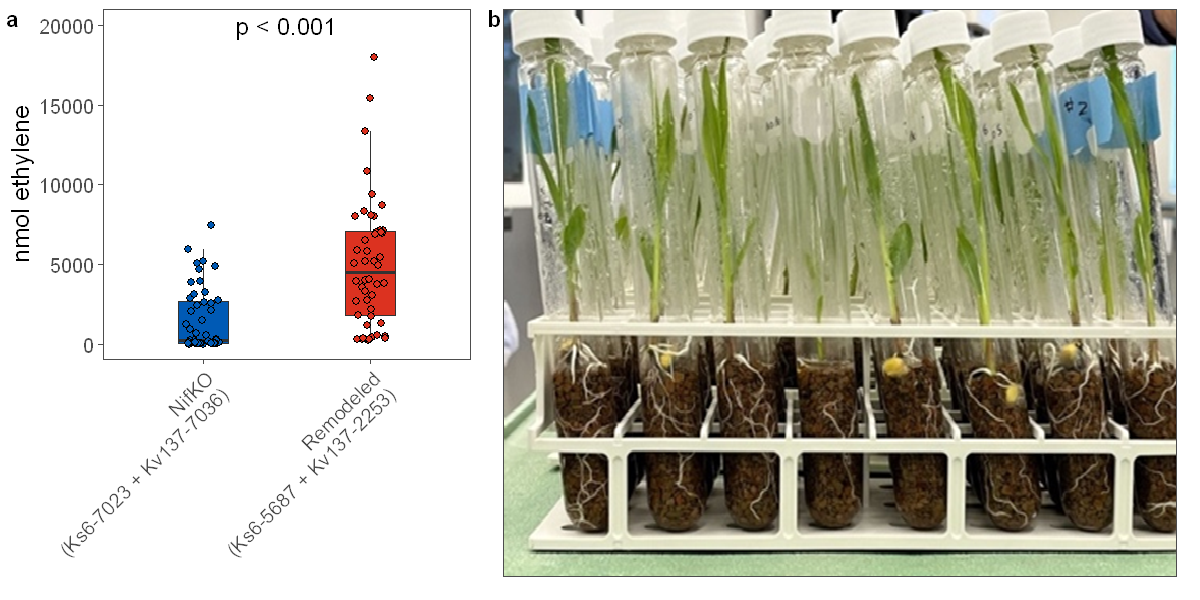

In [8]:
options(repr.plot.width=10, repr.plot.height=5)

ggarrange(ip_ara_plot, ip_ara_pic,labels = c("a", "b"), widths = c(2,3))

# In-planta d15n incorporation  

In [9]:
ip_d15n <-  read_xlsx("./datasets/in_planta_assays.xlsx",2)
names(ip_d15n) <- gsub(" |\\||/|\\(|\\)","_",tolower(names(ip_d15n)))
tail(ip_d15n)

condition,strain_type,strain,batch,d15n,dilution_factor,large_colony_count,small_colony_count,log_cfu
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
15N,Remodeled,6-5687; 137-2253,1,20.78,3,7.67,7.00,7.64
15N,Remodeled,6-5687; 137-2253,1,9.03,3,6.33,9.67,7.68
15N,Remodeled,6-5687; 137-2253,2,12.02,3,7.67,6.00,7.61
15N,Remodeled,6-5687; 137-2253,3,12.51,3,7.33,6.00,7.60
15N,Remodeled,6-5687; 137-2253,3,6.82,3,7.33,6.67,7.62
15N,Remodeled,6-5687; 137-2253,3,16.80,3,6.67,6.33,7.59


In [10]:
ip_d15n <- ip_d15n %>% 
filter(strain_type %in% c("nifKO","Remodeled")) %>%
mutate(gas = factor(condition,levels = c("14N","15N"),labels = c("'Non-enriched (0.367% '^15*N[2]*')'","'Enriched (10.3% '^15*N[2]*')'")),
strain_combo =factor(strain_type, levels =c("nifKO","Remodeled"), labels = c("NifKO\n(Ks6-7023 + Kv137-7036)","Remodeled\n(Ks6-5687 + Kv137-2253)")))

names(ip_d15n)

[1] "condition"          "strain_type"        "strain"            
 [4] "batch"              "d15n"               "dilution_factor"   
 [7] "large_colony_count" "small_colony_count" "log_cfu"           
[10] "gas"                "strain_combo"

## Test of hypothesis

### Check for equal variances


In [11]:
leveneTest(d15n ~ strain_type, data = ip_d15n)
leveneTest(d15n ~ condition, data = ip_d15n)
leveneTest(d15n ~ strain_type*condition, data = ip_d15n)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,3.989292,0.05678402
,25,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,6.629077,0.01633988
,25,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,5.470187,0.005486341
,23,NA,NA


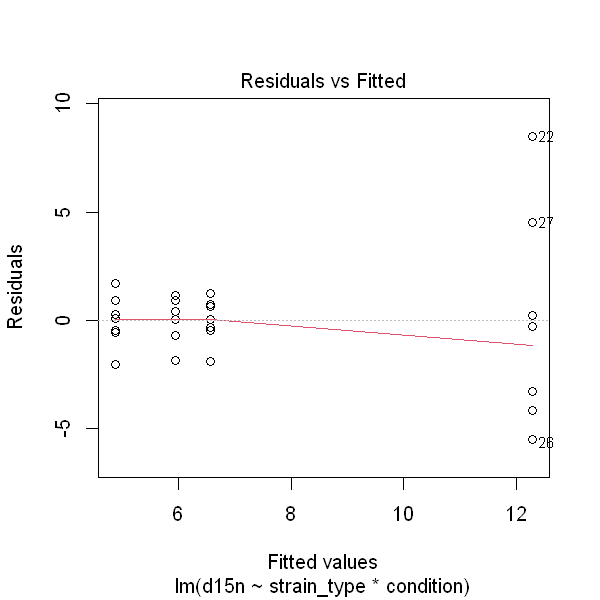

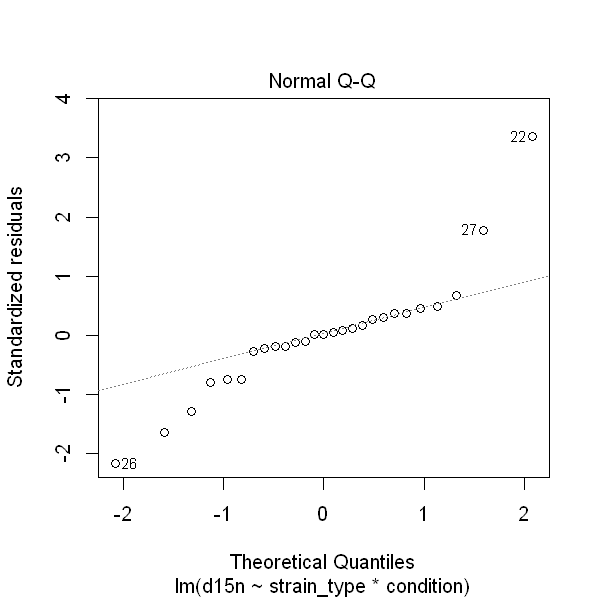

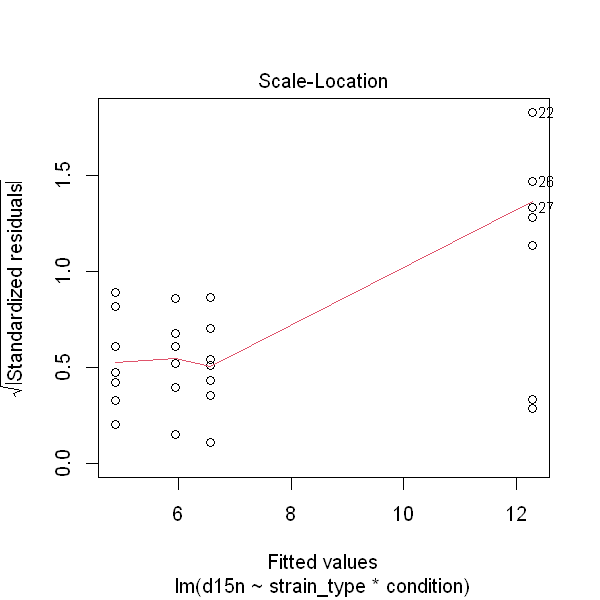

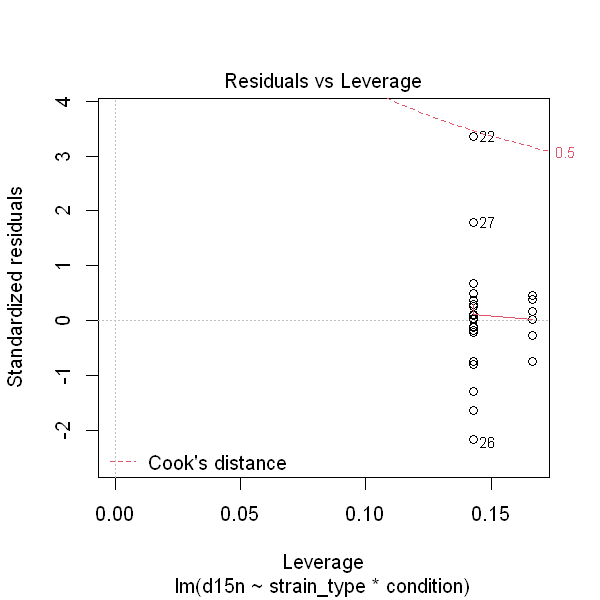

In [12]:
ip_d15n_mod <- lm(d15n ~ strain_type*condition,ip_d15n)

options(repr.plot.width=5, repr.plot.height=5)
plot(ip_d15n_mod)

We seem to have issues with unequal variances, using log-trasnformed units instead.

In [13]:
leveneTest(log(d15n) ~ strain_type, data = ip_d15n)
leveneTest(log(d15n) ~ condition, data = ip_d15n)
leveneTest(log(d15n) ~ strain_type*condition, data = ip_d15n)

Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,2.040752,0.1655095
,25,NA,NA


Warning message in leveneTest.default(y = y, group = group, ...):
"group coerced to factor."


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,9.39978,0.005151041
,25,NA,NA


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,3,1.635943,0.2085801
,23,NA,NA


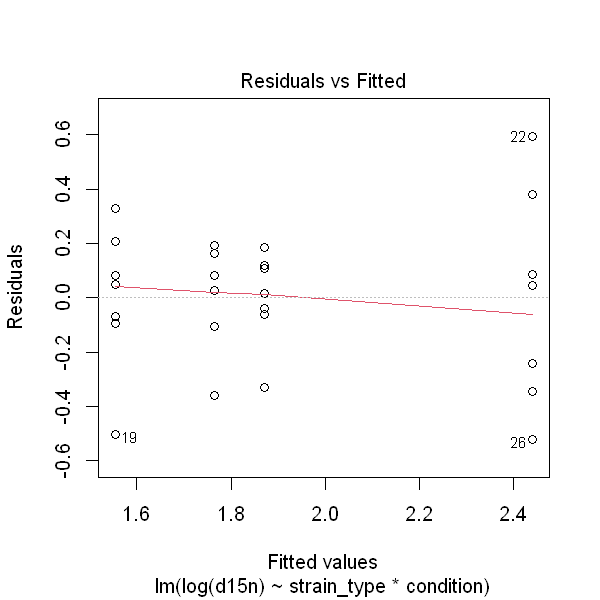

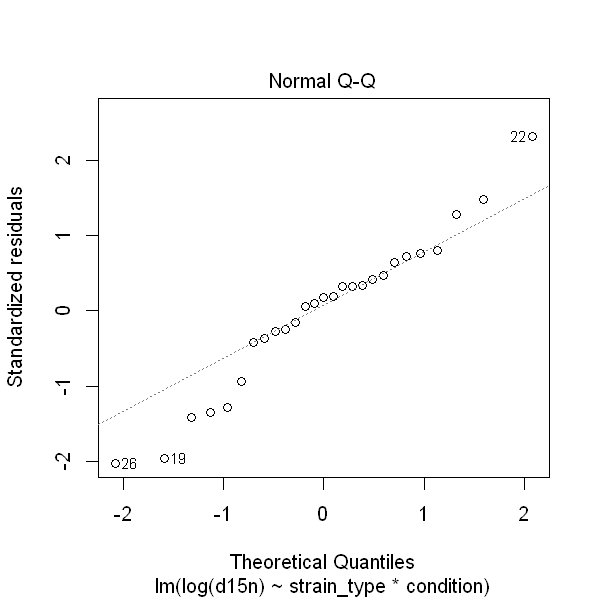

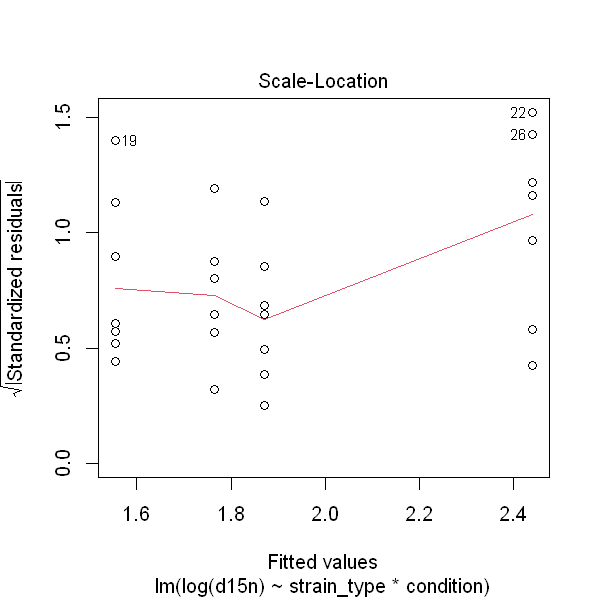

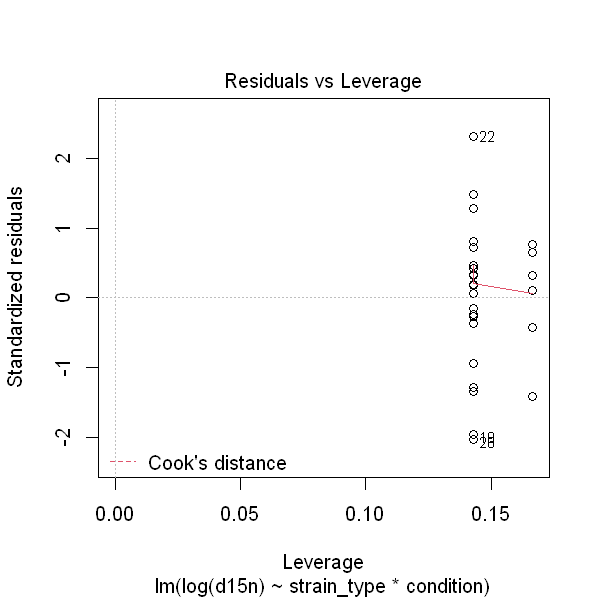

In [14]:
ip_d15n_log_mod <- lm(log(d15n) ~ strain_type*condition,ip_d15n)
plot(ip_d15n_log_mod)

Better.

In [15]:
anova(ip_d15n_log_mod)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
strain_type,1,1.1675032,1.16750318,15.20123,0.0007229098
condition,1,0.1722012,0.17220117,2.24211,0.1478965585
strain_type:condition,1,1.6584773,1.65847734,21.59386,0.0001122198
Residuals,23,1.7664734,0.07680319,NA,NA


In [16]:
ip_d15n_log_mod_means <- emmeans(ip_d15n_log_mod, ~ strain_type, by = "condition", type = "response")
ip_d15n_log_mod_means

condition = 14N:
 strain_type response    SE df lower.CL upper.CL
 nifKO           6.49 0.680 23     5.23     8.06
 Remodeled       5.84 0.660 23     4.62     7.37

condition = 15N:
 strain_type response    SE df lower.CL upper.CL
 nifKO           4.73 0.495 23     3.81     5.87
 Remodeled      11.48 1.203 23     9.24    14.26

Confidence level used: 0.95 
Intervals are back-transformed from the log scale 

In [17]:
ip_d15n_log_mod_contrasts <- pairs(ip_d15n_log_mod_means, reverse = TRUE,  adjust = "Tukey") %>% 
data.frame() %>% 
mutate(my_label = paste0(ifelse(p.value > 0.001,paste0("p = ", signif(p.value,3)),"p < 0.001"))) %>% 
left_join(dplyr::select(ip_d15n,condition,gas) %>% unique())


ip_d15n_log_mod_contrasts

Joining with `by = join_by(condition)`


contrast,condition,ratio,SE,df,null,t.ratio,p.value,my_label,gas
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
Remodeled / nifKO,14N,0.8988527,0.1385879,23,1,-0.6916198,4.960989e-01,p = 0.496,'Non-enriched (0.367% '^15*N[2]*')'
Remodeled / nifKO,15N,2.4276841,0.3596233,23,1,5.9873897,4.181363e-06,p < 0.001,'Enriched (10.3% '^15*N[2]*')'


In [18]:
ip_d15n_plot <- ip_d15n %>% 
ggplot(aes(strain_combo,d15n)) + 
geom_boxplot(aes(fill = strain_combo), outlier.color  = "white", width = 0.3) + 
geom_jitter(aes(fill = strain_combo),shape = 21, size = 2, width = 0.1) +
geom_text(aes(y = 25, x = 1.5, label = my_label), data = ip_d15n_log_mod_contrasts, vjust = 1, size = 5) + 
facet_grid(~gas, labeller = label_parsed) + 
scale_fill_manual(values = myColorPalette, labels = parse_format()) +
#annotate("text", y = 20000, x = 1.5, label = mylab, size = 6) + 
scale_y_continuous(sec.axis = sec_axis(~ (.*0.000367 + 0.367), name = expression(Atom~""^15*N~Excess~"(%)"))) + 
theme(legend.position = "none", axis.text.x = element_text(size = 12, angle = 45, hjust = 1, vjust = 1)) + 
labs(y = expression(delta^15*N~"in chlorophyll (‰)"), x = "", title = "Gas in chamber")

In [19]:
ip_d15n_pic <- ggplot() + 
    background_image(readPNG("./datasets/ip_d15n_incorp.png")) +
    # This ensures that the image leaves some space at the edges
    theme(plot.margin = margin(t=0.5, l=1.5, r=0.5, b=0.5, unit = "cm"))

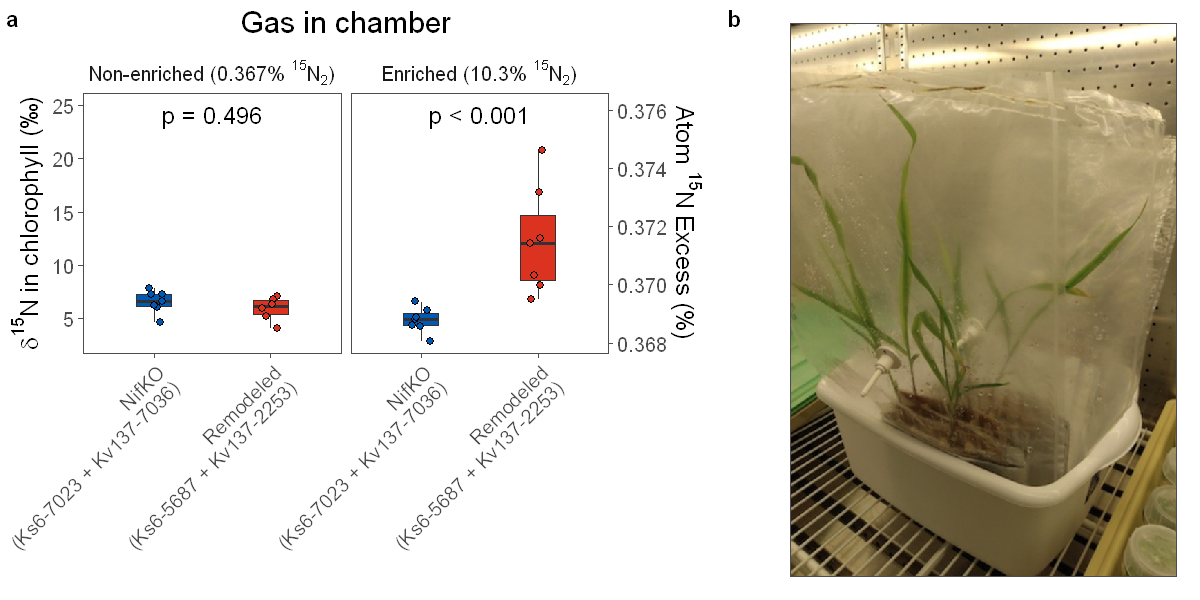

In [20]:
options(repr.plot.width=10, repr.plot.height=5)

ggarrange(ip_d15n_plot, ip_d15n_pic,labels = c("a", "b"), widths = c(3,2))

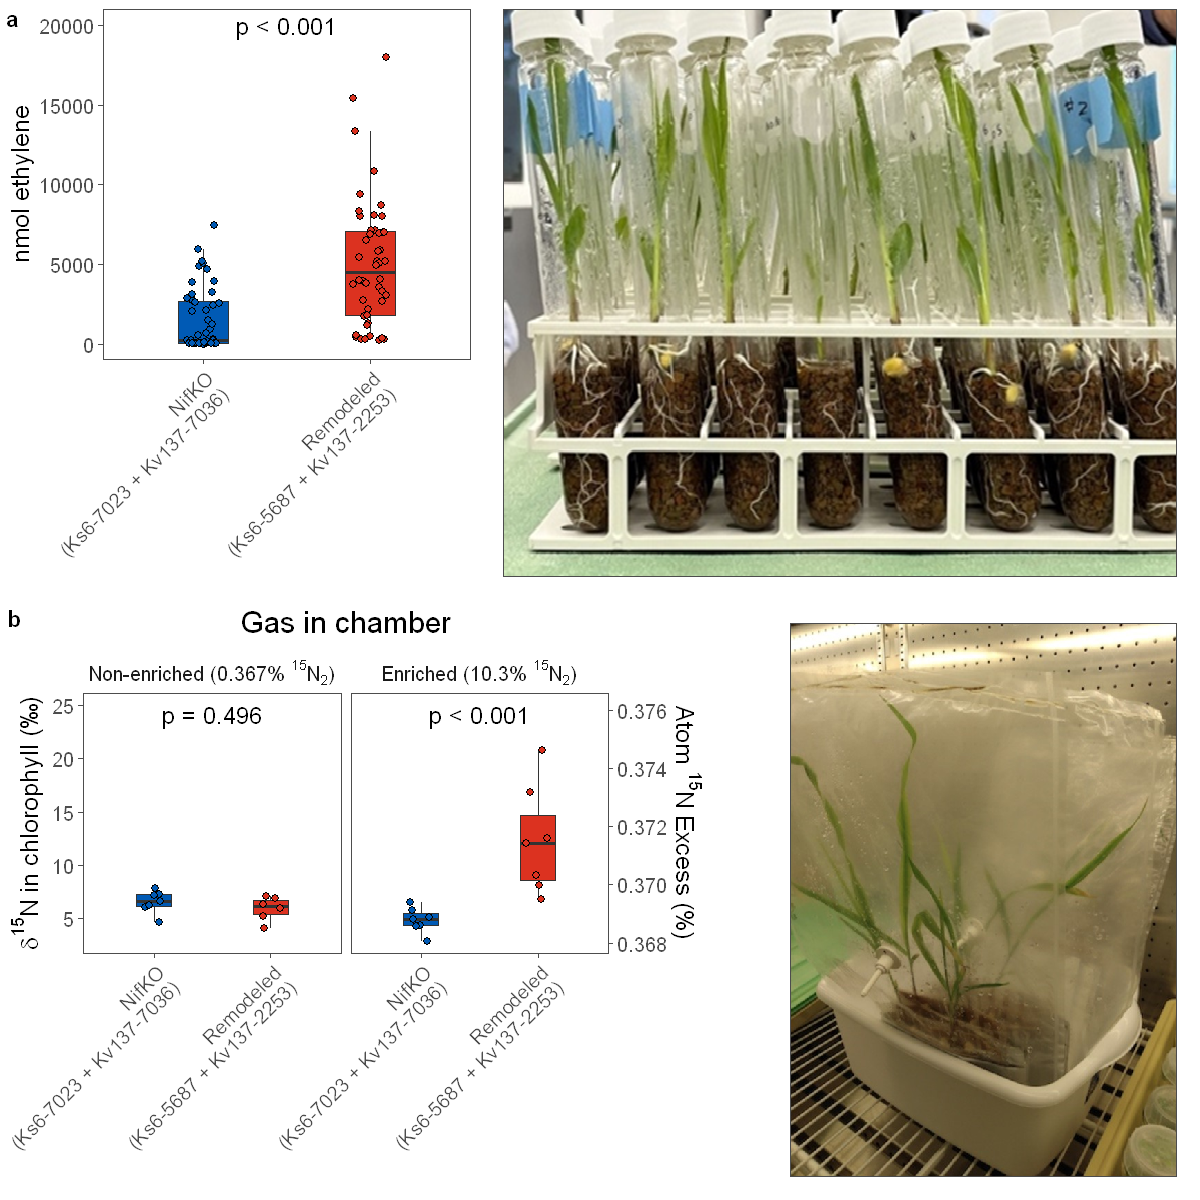

In [21]:
options(repr.plot.width=10, repr.plot.height=10)

ggarrange(
    ggarrange(ip_ara_plot, ip_ara_pic, widths = c(2,3)),
    ggarrange(ip_d15n_plot, ip_d15n_pic, widths = c(3,2)),
    nrow = 2,
    labels = c("a","b")
)


In [22]:
ggsave("./figures/in_planta_assays.png",width = 10, height = 10, dpi = 300)